# 1. Utilities

## 1.1 Imports


In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from A2C_clean import A2C
from tqdm import tqdm
import os
%load_ext autoreload
%autoreload 2

## 1.2 Create Environment


In [3]:
# environment hyperparams
#option 1 :  use n_updates to define n_steps
n_updates = 50000
n_envs = 1
n_steps_per_update = 1
#n_steps = n_envs * n_steps_per_update * n_updates

#option 2 :  use n_steps to define n_updates
#n_steps = 500000
#n_updates = n_steps // (n_envs * n_steps_per_update) # number of updates

# agent hyperparams
gamma = 0.99  # discount factor
ent_coef = 0.01  # coefficient for the entropy bonus (to encourage exploration)
actor_lr = 1e-5
critic_lr = 1e-3

# Note: the actor has a slower learning rate so that the value targets become
# more stationary and are theirfore easier to estimate for the critic

# environment setup
#envs = gym.vector.make("CartPole-v1", num_envs=n_envs)
env = gym.make("CartPole-v1")

obs_shape = env.observation_space.shape[0]
print(obs_shape)
action_shape = env.action_space.n
print(action_shape)
# set the device
use_cuda = False
if use_cuda:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

# init the agent
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs = 1)

4
2


In [5]:
# create a wrapper environment to save episode returns and episode lengths

critic_losses = []
actor_losses = []
entropies = []
evaluation_returns = []
steps = 0
is_truncated = [False]
is_terminated = [False]
rewards_list = []
ep_counter = 0
log_terminated_steps = []
log_truncated_steps = []


# use tqdm to get a progress bar for training
for sample_phase in tqdm(range(n_updates)):
    # we don't have to reset the envs, they just continue playing
    # until the episode is over and then reset automatically

    # reset lists that collect experiences of an episode (sample phase)
    ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    masks = torch.zeros(n_steps_per_update, n_envs, device=device) 
    should_print = False
    # at the start of training reset all envs to get an initial state
    if is_truncated[0] == True or is_terminated[0] == True or steps == 0:
        states, info = env.reset(seed=42)
        ep_counter += 1
        #rewards_list.append()

    # play n steps in our parallel environments to collect data
    for step in range(n_steps_per_update):
        # select an action A_{t} using S_{t} as input for the agent
        actions, action_log_probs, state_value_preds, entropy = agent.select_action(states, bool_greedy=False)

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        states, rewards, terminated, truncated, infos = env.step(
            actions.cpu().numpy()
        )
        
        if terminated or truncated:
            # print(f"truncated: {truncated}, terminated: {terminated}, steps: {steps}")
            # print(f"infos: {infos}  ")
            # print("****")
            if terminated:
                print("Terminated at episode: ", steps)
                log_terminated_steps.append(steps)
            if truncated:
                print("Truncated at episode: ", steps)
                log_truncated_steps.append(steps)
            #should_print = True

        is_truncated = [truncated]
        is_terminated = [terminated]
        steps += 1

        ep_value_preds[step] = torch.squeeze(state_value_preds)
        ep_rewards[step] = torch.tensor(rewards, device=device)
        ep_action_log_probs[step] = action_log_probs
        # for each env the mask is 1 if the episode is ongoing and 0 if it is terminated (not by truncation!)
        masks[step] = torch.tensor(not terminated) # allows for correct bootstrapping
        #masks[step] = 1
    states_tensor = torch.tensor(states, device=device) # Transform the last state reached (S_t+n) to a tensor

    # calculate the losses for actor and critic
    critic_loss, actor_loss = agent.get_losses(
        ep_rewards,
        ep_action_log_probs,
        ep_value_preds,
        entropy,
        masks,
        gamma,
        states_tensor,
        should_print
    )

    # update the actor and critic networks
    agent.update_parameters(critic_loss, actor_loss)

    # log the losses and entropy
    critic_losses.append(critic_loss.detach().cpu().numpy())
    actor_losses.append(actor_loss.detach().cpu().numpy())
    entropies.append(entropy.detach().mean().cpu().numpy())

print(ep_counter)




  0%|          | 0/50000 [00:00<?, ?it/s]/Users/alexis/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  1%|          | 541/50000 [00:00<00:36, 1346.94it/s]

Terminated at episode:  407


  2%|▏         | 1061/50000 [00:00<00:40, 1208.14it/s]

Terminated at episode:  847


  3%|▎         | 1603/50000 [00:01<00:36, 1316.68it/s]

Truncated at episode:  1347


  4%|▍         | 2022/50000 [00:01<00:34, 1372.23it/s]

Terminated at episode:  1761
Terminated at episode:  1889


  5%|▍         | 2437/50000 [00:01<00:34, 1376.45it/s]

Terminated at episode:  2165


  5%|▌         | 2714/50000 [00:02<00:34, 1376.35it/s]

Terminated at episode:  2574


  6%|▋         | 3141/50000 [00:02<00:33, 1397.96it/s]

Terminated at episode:  2996


  7%|▋         | 3570/50000 [00:02<00:33, 1403.51it/s]

Terminated at episode:  3359


  8%|▊         | 3850/50000 [00:02<00:34, 1333.19it/s]

Terminated at episode:  3684


  9%|▉         | 4408/50000 [00:03<00:33, 1381.27it/s]

Truncated at episode:  4184


 10%|▉         | 4828/50000 [00:03<00:32, 1389.14it/s]

Truncated at episode:  4684
Terminated at episode:  4893


 11%|█         | 5538/50000 [00:04<00:31, 1412.67it/s]

Terminated at episode:  5340


 12%|█▏        | 6102/50000 [00:04<00:31, 1395.34it/s]

Truncated at episode:  5840


 13%|█▎        | 6522/50000 [00:04<00:31, 1386.62it/s]

Terminated at episode:  6312


 14%|█▍        | 6937/50000 [00:05<00:32, 1340.71it/s]

Terminated at episode:  6781


 15%|█▍        | 7345/50000 [00:05<00:33, 1292.36it/s]

Terminated at episode:  7203


 16%|█▌        | 7764/50000 [00:05<00:31, 1351.65it/s]

Terminated at episode:  7517


 16%|█▌        | 8036/50000 [00:05<00:31, 1346.67it/s]

Terminated at episode:  7852
Terminated at episode:  8102


 17%|█▋        | 8574/50000 [00:06<00:35, 1178.02it/s]

Terminated at episode:  8413


 18%|█▊        | 8979/50000 [00:06<00:31, 1298.71it/s]

Terminated at episode:  8791


 19%|█▉        | 9541/50000 [00:07<00:29, 1374.55it/s]

Truncated at episode:  9291


 20%|█▉        | 9959/50000 [00:07<00:28, 1382.97it/s]

Truncated at episode:  9791


 21%|██        | 10524/50000 [00:07<00:28, 1402.76it/s]

Truncated at episode:  10291


 22%|██▏       | 10805/50000 [00:08<00:29, 1307.92it/s]

Terminated at episode:  10637
Terminated at episode:  10882


 23%|██▎       | 11646/50000 [00:08<00:27, 1390.22it/s]

Truncated at episode:  11382


 24%|██▍       | 12067/50000 [00:08<00:27, 1391.14it/s]

Terminated at episode:  11861
Terminated at episode:  12123


 26%|██▌       | 12772/50000 [00:09<00:26, 1381.22it/s]

Terminated at episode:  12509
Terminated at episode:  12794


 27%|██▋       | 13337/50000 [00:09<00:26, 1402.43it/s]

Terminated at episode:  13166


 28%|██▊       | 13766/50000 [00:10<00:25, 1408.29it/s]

Terminated at episode:  13541


 28%|██▊       | 14191/50000 [00:10<00:25, 1401.80it/s]

Truncated at episode:  14041


 30%|██▉       | 14760/50000 [00:10<00:24, 1415.53it/s]

Truncated at episode:  14541


 30%|███       | 15186/50000 [00:11<00:24, 1406.88it/s]

Truncated at episode:  15041


 31%|███▏      | 15748/50000 [00:11<00:26, 1269.52it/s]

Truncated at episode:  15541


 33%|███▎      | 16309/50000 [00:12<00:24, 1370.46it/s]

Truncated at episode:  16041


 33%|███▎      | 16733/50000 [00:12<00:23, 1388.63it/s]

Truncated at episode:  16541


 34%|███▍      | 17157/50000 [00:12<00:23, 1404.77it/s]

Terminated at episode:  16905
Terminated at episode:  17082


 35%|███▌      | 17584/50000 [00:13<00:23, 1407.46it/s]

Terminated at episode:  17359


 36%|███▌      | 18011/50000 [00:13<00:22, 1410.50it/s]

Truncated at episode:  17859


 37%|███▋      | 18441/50000 [00:13<00:23, 1362.12it/s]

Terminated at episode:  18180


 38%|███▊      | 18864/50000 [00:13<00:22, 1396.24it/s]

Terminated at episode:  18666


 39%|███▊      | 19287/50000 [00:14<00:21, 1402.55it/s]

Terminated at episode:  19091


 40%|███▉      | 19857/50000 [00:14<00:21, 1414.00it/s]

Truncated at episode:  19591


 41%|████      | 20284/50000 [00:15<00:21, 1409.58it/s]

Terminated at episode:  20074


 42%|████▏     | 20853/50000 [00:15<00:20, 1417.24it/s]

Truncated at episode:  20574


 43%|████▎     | 21271/50000 [00:15<00:21, 1353.88it/s]

Truncated at episode:  21074


 44%|████▎     | 21840/50000 [00:16<00:19, 1410.06it/s]

Truncated at episode:  21574


 45%|████▍     | 22268/50000 [00:16<00:19, 1410.82it/s]

Truncated at episode:  22074


 46%|████▌     | 22842/50000 [00:16<00:19, 1420.59it/s]

Truncated at episode:  22574


 47%|████▋     | 23269/50000 [00:17<00:19, 1404.11it/s]

Truncated at episode:  23074


 48%|████▊     | 23834/50000 [00:17<00:19, 1337.38it/s]

Truncated at episode:  23574


 49%|████▊     | 24258/50000 [00:17<00:18, 1387.63it/s]

Truncated at episode:  24074


 50%|████▉     | 24830/50000 [00:18<00:17, 1421.08it/s]

Truncated at episode:  24574


 51%|█████     | 25258/50000 [00:18<00:17, 1410.23it/s]

Truncated at episode:  25074


 52%|█████▏    | 25834/50000 [00:18<00:16, 1429.04it/s]

Truncated at episode:  25574


 53%|█████▎    | 26265/50000 [00:19<00:16, 1426.08it/s]

Truncated at episode:  26074


 54%|█████▎    | 26836/50000 [00:19<00:16, 1385.46it/s]

Truncated at episode:  26574


 55%|█████▍    | 27257/50000 [00:20<00:16, 1387.54it/s]

Truncated at episode:  27074


 56%|█████▌    | 27829/50000 [00:20<00:15, 1417.66it/s]

Truncated at episode:  27574


 57%|█████▋    | 28258/50000 [00:20<00:15, 1421.46it/s]

Truncated at episode:  28074


 57%|█████▋    | 28689/50000 [00:21<00:15, 1415.73it/s]

Terminated at episode:  28432


 58%|█████▊    | 29112/50000 [00:21<00:16, 1290.17it/s]

Truncated at episode:  28932


 59%|█████▉    | 29668/50000 [00:21<00:14, 1363.21it/s]

Truncated at episode:  29432


 60%|██████    | 30092/50000 [00:22<00:14, 1399.66it/s]

Truncated at episode:  29932


 61%|██████▏   | 30665/50000 [00:22<00:13, 1413.34it/s]

Truncated at episode:  30432


 62%|██████▏   | 31080/50000 [00:22<00:15, 1257.26it/s]

Truncated at episode:  30932


 63%|██████▎   | 31618/50000 [00:23<00:14, 1292.56it/s]

Truncated at episode:  31432


 64%|██████▍   | 32172/50000 [00:23<00:13, 1347.87it/s]

Truncated at episode:  31932


 65%|██████▌   | 32585/50000 [00:23<00:12, 1344.63it/s]

Terminated at episode:  32426


 66%|██████▋   | 33151/50000 [00:24<00:12, 1381.85it/s]

Truncated at episode:  32926


 67%|██████▋   | 33569/50000 [00:24<00:12, 1349.36it/s]

Truncated at episode:  33426


 68%|██████▊   | 34131/50000 [00:25<00:11, 1355.44it/s]

Truncated at episode:  33926


 69%|██████▉   | 34551/50000 [00:25<00:11, 1387.40it/s]

Terminated at episode:  34369


 70%|███████   | 35107/50000 [00:25<00:10, 1368.30it/s]

Truncated at episode:  34869


 71%|███████   | 35513/50000 [00:26<00:10, 1334.30it/s]

Truncated at episode:  35369


 72%|███████▏  | 35934/50000 [00:26<00:10, 1383.45it/s]

Terminated at episode:  35749


 73%|███████▎  | 36357/50000 [00:26<00:09, 1396.56it/s]

Terminated at episode:  36135


 74%|███████▎  | 36778/50000 [00:27<00:09, 1340.33it/s]

Terminated at episode:  36545


 74%|███████▍  | 37195/50000 [00:27<00:09, 1374.19it/s]

Truncated at episode:  37045


 75%|███████▍  | 37479/50000 [00:27<00:09, 1385.10it/s]

Terminated at episode:  37355


 76%|███████▌  | 38048/50000 [00:28<00:08, 1337.48it/s]

Terminated at episode:  37784


 77%|███████▋  | 38468/50000 [00:28<00:08, 1381.71it/s]

Terminated at episode:  38246


 78%|███████▊  | 38890/50000 [00:28<00:07, 1392.90it/s]

Truncated at episode:  38746


 79%|███████▉  | 39461/50000 [00:29<00:07, 1373.51it/s]

Truncated at episode:  39246


 80%|████████  | 40030/50000 [00:29<00:07, 1413.60it/s]

Truncated at episode:  39746


 81%|████████  | 40455/50000 [00:29<00:06, 1407.76it/s]

Truncated at episode:  40246


 82%|████████▏ | 41022/50000 [00:30<00:06, 1408.56it/s]

Truncated at episode:  40746


 83%|████████▎ | 41449/50000 [00:30<00:06, 1418.21it/s]

Truncated at episode:  41246


 84%|████████▍ | 42023/50000 [00:30<00:05, 1426.11it/s]

Truncated at episode:  41746


 85%|████████▍ | 42449/50000 [00:31<00:05, 1370.07it/s]

Truncated at episode:  42246


 86%|████████▌ | 43013/50000 [00:31<00:04, 1402.61it/s]

Truncated at episode:  42746


 87%|████████▋ | 43437/50000 [00:31<00:04, 1389.07it/s]

Truncated at episode:  43246


 88%|████████▊ | 44007/50000 [00:32<00:04, 1415.29it/s]

Truncated at episode:  43746


 89%|████████▉ | 44436/50000 [00:32<00:03, 1418.37it/s]

Truncated at episode:  44246


 90%|█████████ | 45009/50000 [00:33<00:03, 1375.80it/s]

Truncated at episode:  44746


 91%|█████████ | 45431/50000 [00:33<00:03, 1393.55it/s]

Truncated at episode:  45246


 92%|█████████▏| 46001/50000 [00:33<00:02, 1414.90it/s]

Truncated at episode:  45746


 93%|█████████▎| 46428/50000 [00:34<00:02, 1410.97it/s]

Truncated at episode:  46246


 94%|█████████▍| 47001/50000 [00:34<00:02, 1420.46it/s]

Truncated at episode:  46746


 95%|█████████▍| 47427/50000 [00:34<00:01, 1406.08it/s]

Truncated at episode:  47246


 96%|█████████▌| 47998/50000 [00:35<00:01, 1394.29it/s]

Truncated at episode:  47746


 97%|█████████▋| 48423/50000 [00:35<00:01, 1396.11it/s]

Truncated at episode:  48246


 98%|█████████▊| 48994/50000 [00:35<00:00, 1416.36it/s]

Truncated at episode:  48746


 99%|█████████▉| 49421/50000 [00:36<00:00, 1408.00it/s]

Truncated at episode:  49246


100%|██████████| 50000/50000 [00:36<00:00, 1365.59it/s]

Truncated at episode:  49746
112


[407, 847, 1761, 1889, 2165, 2574, 2996, 3359, 3684, 4893, 5340, 6312, 6781, 7203, 7517, 7852, 8102, 8413, 8791, 10637, 10882, 11861, 12123, 12509, 12794, 13166, 13541, 16905, 17082, 17359, 18180, 18666, 19091, 20074, 28432, 32426, 34369, 35749, 36135, 36545, 37355, 37784, 38246]
truncated [1347, 4184, 4684, 5840, 9291, 9791, 10291, 11382, 14041, 14541, 15041, 15541, 16041, 16541, 17859, 19591, 20574, 21074, 21574, 22074, 22574, 23074, 23574, 24074, 24574, 25074, 25574, 26074, 26574, 27074, 27574, 28074, 28932, 29432, 29932, 30432, 30932, 31432, 31932, 32926, 33426, 33926, 34869, 35369, 37045, 38746, 39246, 39746, 40246, 40746, 41246, 41746, 42246, 42746, 43246, 43746, 44246, 44746, 45246, 45746, 46246, 46746, 47246, 47746, 48246, 48746, 49246, 49746]
[407, 847, 1761, 1889, 2996, 3359, 3684, 4891, 4893, 5147, 5340, 6312, 6780, 6781, 7073, 7203, 7517, 7852, 8102, 8413, 8791, 10637, 10882, 11861, 12123, 13166, 16905, 17082, 17258, 17359, 18180, 18666, 19091, 20074, 28432, 32426, 34369, 3

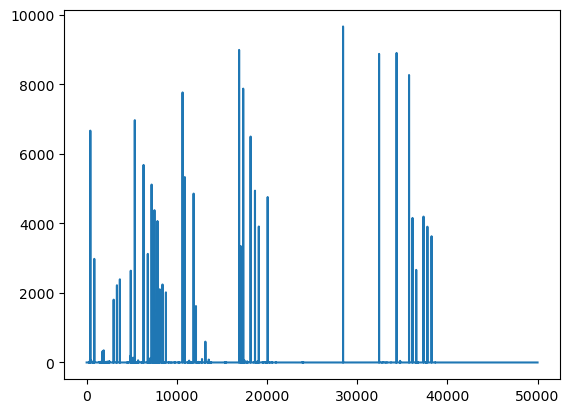

In [8]:

#plot evaluation
print(log_terminated_steps)
print("truncated",log_truncated_steps)
longueur = len(log_terminated_steps)
indexes = np.argsort(critic_losses)[-longueur:]
print(sorted(indexes))
print(np.mean(critic_losses))


#plt.plot(np.log(critic_losses))
plt.plot(critic_losses)
# plt.plot(evaluation_returns)
# Example list


# Get the indexes of the 10 largest values


#print(indexes)
# plt.title("Evaluation Returns")
# plt.xlabel("Evaluation number")
# plt.ylabel("Average return")




plt.show()


## saving/loading weights

In [9]:
save_weights = True
load_weights = False

actor_weights_path = "weights/actor_weightss.h5"
critic_weights_path = "weights/critic_weightss.h5"

if not os.path.exists("weights"):
    os.mkdir("weights")

""" save network weights """
if save_weights:
    torch.save(agent.actor.state_dict(), actor_weights_path)
    torch.save(agent.critic.state_dict(), critic_weights_path)


""" load network weights """
if load_weights:
    agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, 1)

    agent.actor.load_state_dict(torch.load(actor_weights_path))
    agent.critic.load_state_dict(torch.load(critic_weights_path))
    agent.actor.eval()
    agent.critic.eval()

## SHOWCASE

In [10]:
n_showcase_episodes = 3

for episode in range(n_showcase_episodes):
    print(f"starting episode {episode}...")

    # create a new sample environment to get new random parameters
    env = gym.make("CartPole-v1", render_mode="human", max_episode_steps=500)

    # get an initial state
    state, info = env.reset()

    # play one episode
    done = False
    while not done:
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _, _ = agent.select_action(state[None, :], bool_greedy=True)

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action.item())

        # update if the environment is done
        done = terminated or truncated

env.close()

starting episode 0...


/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


starting episode 1...
starting episode 2...


: 

### 1.2.1 Printing informations

In [ ]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print("------")
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

NameError: name 'env' is not defined

## 1.3 Define the A2C Class


# 2. Running the Agents (Discrete Case)


A2C.py and then we merge


In [ ]:
from A2C import *

## 1.4 Training function



train.py and then we merge


In [ ]:
from training import *

## 1.5 Evaluation functions

# 2. Running the Agents (Discrete Case)


## 2.1 Agent 1

# 3. Running the Agents (Continuous Case)
